# Spike sorting workflow

In [2]:
%load_ext autoreload
%autoreload 2
from herdingspikes import spikeclass, ImportInterpolated
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Import the detected spikes

In [3]:
# load an unsorted data set recorded at 24kHz (1024 channels, 42um pitch)
path = 'test_datasets/'
fname = 'partial_smallarray_fullfield_retinal_recording_v28.hdf5'
O = ImportInterpolated(path+fname, shapesrange=(18,62))
# cut-outs are longer than required, so cropped here between frame 18 and 62

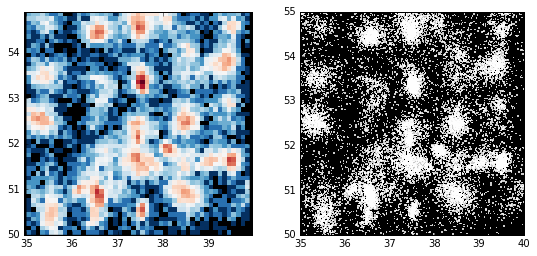

In [4]:
plt.figure(figsize=(9,4))
ax = plt.subplot (121)
O.LogHistPlot(ax=ax, binstep=0.1);
ax = plt.subplot(122)
O.DataPlot(ax=ax, show_max=int(2e4));

## Remove noise

Spikes are detected with a low threshold and minimal shape criteria to minimise false negatives. The plots above show that areas where little or no activity was recorded still contain events. These are removed in the following with a classifier, which is a support vector machine trained on examples of events found in low density regions and events with larger amplitudes. 

In [10]:
# compute PCA
%time
scorePCA = O.ShapePCA(ncomp=4, white=True)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.81 µs
Starting sklearn PCA...
using all 18789 shapes...
done.


Working with 2088 examples of bad shapes.
Working with 13209 examples of good shapes.
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.81 µs
Classified as bad: 8222, and as good: 10567


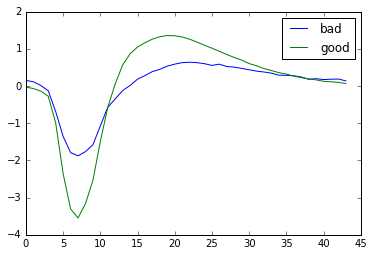

In [11]:
# obtain training data, train the classifier with a subset and then assign spikes to their classes
SC = O.ShapeClassifier()
badshape, indbad = SC.BadShapesByDensity(percentile=0.5, min_thr=1)
goodshape, indgood = SC.GoodShapesByAmplitude(2.5)
plt.plot(badshape, label = 'bad')
plt.plot(goodshape, label='good')
plt.legend()
%time
shapeScore = SC.FitClassifier(scorePCA, indgood[:1000], indbad[:1000])

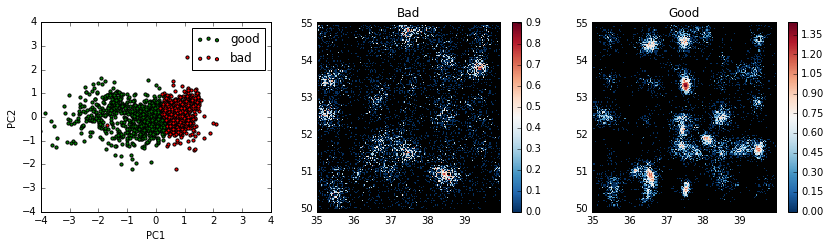

In [15]:
plt.figure(figsize=(14,3.4))
plt.subplot(131)
plt.scatter(scorePCA[0,shapeScore==1][:1000], scorePCA[1,shapeScore==1][:1000], c='g', label='good', s=10)
plt.scatter(scorePCA[0,shapeScore==0][:1000], scorePCA[1,shapeScore==0][:1000], c='r', label='bad', s=10)
plt.xlim((-4,4))
plt.ylim((-4,4))
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
ax = plt.subplot(132)
O.LogHistPlot(ax=ax, binstep=0.03, inds=shapeScore==0);
plt.title('Bad')
plt.colorbar()
ax = plt.subplot(133)
O.LogHistPlot(ax=ax, binstep=0.03, inds=shapeScore==1);
plt.colorbar()
plt.title('Good');

This procedure removes many events that are either very likely noise as they were detecetd in areas without any clear spatial clustering, or small events without a clear spike signature (in particular the positive repolarisation phase). Note that while the first principal component predictes the separation well, the decision boundary is not linear. 

In [16]:
# remove all events classified as noise
O.KeepOnly(shapeScore==1)

## Cluster the remaining events into single units

In [17]:
%%time
O.CombinedMeanShift(0.3, 0.28, PrincComp=scorePCA[:2,shapeScore==1] )

Starting sklearn Mean Shift... 
done.
CPU times: user 136 ms, sys: 16 ms, total: 152 ms
Wall time: 715 ms


In [18]:
print('Found '+str(O.NClusters())+' clusters for '+str(O.NData())+' spikes.')

Found 62 clusters for 10567 spikes.


/home/martino/Documents/herding-spikes/clustering/herdingspikes.py:248: UserWarning: Only the first 12 of the given clusters are shown
  warnings.warn("Only the first 12 of the given clusters are shown")


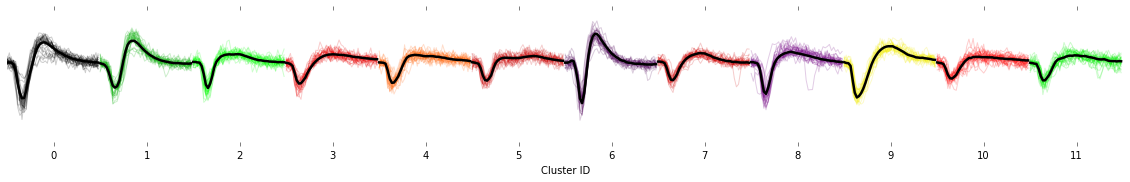

In [19]:
# show waveforms of 12 example clusters
O.ShapesPlot()

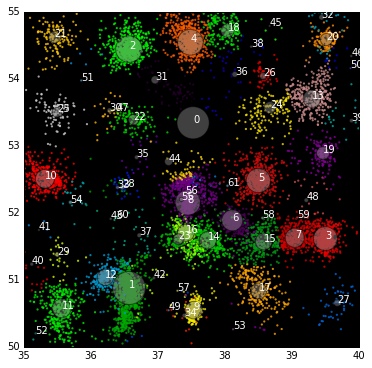

In [20]:
plt.figure(figsize=(6,6))
O.PlotRegion((35,40,50,55), ax=plt.gca())

## The quality of the clustering can be assessed by computing a confusion matrix using a fit with a mixtures of Gaussians model

In [21]:
Q=O.QualityMeasures(scorePCA=scorePCA[:,shapeScore==1])

In [22]:
%%time
# Here all clusters with at least 100 spikes are assessed in turn.
# Their nearest neighbours are found, and a Gaussian mixture is fit to the combined data.
# Responsibilities are then used to compute a confusion maric, which yields false positives and negatives.
clusters = np.where(O.ClusterSizes()>100)[0]
fp = np.zeros(len(clusters))
fn = np.zeros(len(clusters))
for i,c in enumerate(clusters):
    cl = np.hstack((c,Q.Neighbours(c, 1., min_neigh_size=100)))
    conf = Q.GaussianOverlapGroup(cl)
    fp[i] = conf[0,0]
    fn[i] = np.sum(conf-np.diag(np.diag(conf)),axis=0)[0]


CPU times: user 520 ms, sys: 1.03 s, total: 1.55 s
Wall time: 402 ms


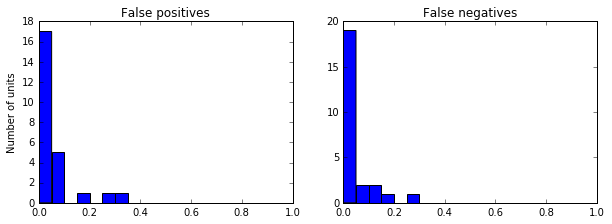

In [23]:
plt.figure(figsize=(10,3.25))
plt.subplot(121)
plt.hist(fp, bins=np.arange(0,1,0.05))
plt.title('False positives')
plt.ylabel('Number of units')
plt.subplot(122)
plt.hist(fn, bins=np.arange(0,1,0.05))
plt.title('False negatives')

## Now evaluate the effect of the clustering parameters on the small section

Crop removed 0 clusters and 0 datapoints.
62 clusters found.


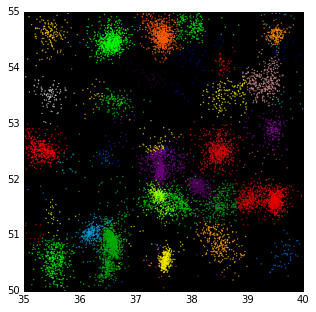

In [24]:
cropInds, cropCl = O.Crop((35, 40, 50, 55))
cropPCA = scorePCA[:,shapeScore==1][:, cropInds]
O.DataPlot(figsize=(5,5), show_max=None)
print(str(O.NClusters())+" clusters found.")

The original clusters, obtained by clustering combined location and shape parameter.

Starting sklearn Mean Shift... 
done.
169 clusters found.
CPU times: user 216 ms, sys: 40 ms, total: 256 ms
Wall time: 1.49 s


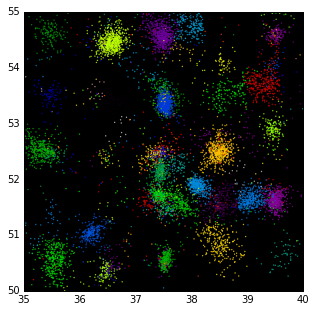

In [25]:
%%time
O.CombinedMeanShift(0.3, 0.5, PrincComp=cropPCA[:2] )
O.DataPlot(figsize=(5,5), show_max=None)
print(str(O.NClusters())+" clusters found.")

More weight on shapes causes clusters to be broken apart (parameter $\alpha=0.5$).

Starting sklearn Mean Shift... 
done.
29 clusters found.
CPU times: user 164 ms, sys: 20 ms, total: 184 ms
Wall time: 363 ms


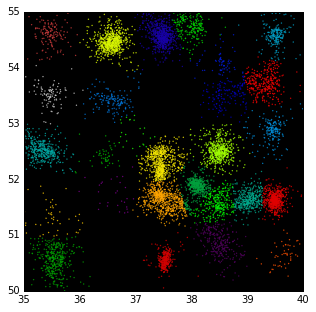

In [26]:
%%time
O.CombinedMeanShift(0.3, 0.0, PrincComp=cropPCA[:2] )
O.DataPlot(figsize=(5,5), show_max=None)
print(str(O.NClusters())+" clusters found.")

Using only spatial information ($\alpha=0$) causes merging of clusters.